# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [1]:
import os
import json
import jsonlines
import numpy as np
from tqdm import tqdm
from collections import defaultdict

## II. Neural Language Modeling with a Recurrent Neural Network

In [2]:
import torch
import torch.nn as nn

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

In [3]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

datasets,vocab = load_wikitext()

Vocab size: 33175


In [ ]:
raw_train = datasets["train"]
raw_val = datasets["valid"]
raw_test = datasets["test"]
print(list(map(len,(raw_train,raw_val,raw_test))))


In [4]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
        # include test
        for line in tqdm(datasets['test']):
            for w in line:
                self.add_token(w)
        
        
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [5]:
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [ ]:
# this function slices the input sequence into ngrams i.e.
# [0,1,2,3,4,5] will be sliced into bigrams
# [0,1], [1,2], [2,3], [3,4], [4,5] etc for bigger orders
def slice_sequences_given_order(tokenized_dataset_with_spec, ngram_order=2):
    sliced_datasets = {}
    for split, dataset in tokenized_dataset_with_spec.items():
        _list_of_sliced_ngrams = []
        for seq in tqdm(dataset):
            ngrams = [seq[i:i+ngram_order] for i in range(len(seq)-ngram_order+1)]
            _list_of_sliced_ngrams.extend(ngrams)
        sliced_datasets[split] = _list_of_sliced_ngrams

    return sliced_datasets

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

# Now we create a dataset
class NgramDataset(Dataset):
    def __init__(self, sliced_dataset_split):
        super().__init__()

        # for each sample: [:-1] is input, [-1] is target
        self.sequences = [torch.tensor(i, dtype=torch.long) for i in sliced_dataset_split]
    
    def __getitem__(self, i):
        sample = self.sequences[i]
        return sample

    def __len__(self):
        return len(self.sequences)

def batchify(list_minibatch):
    inp_list = [i[:-1] for i in list_minibatch]
    tar_list = [i[-1] for i in list_minibatch]

    inp_tensor = torch.stack(inp_list, dim=0)
    tar_tensor = torch.stack(tar_list, dim=0)

    return inp_tensor, tar_tensor

In [6]:
wikitext_dict = Dictionary(datasets, include_valid=True)
# checking some example
print(' '.join(datasets['train'][3010]))

encoded = wikitext_dict.encode_token_seq(datasets['train'][3010])
print(f'\n encoded - {encoded}')
decoded = wikitext_dict.decode_idx_seq(encoded)
print(f'\n decoded - {decoded}')



100%|██████████| 9708/9708 [00:10<00:00, 940.59it/s] 

The Nataraja and Ardhanarishvara sculptures are also attributed to the Rashtrakutas .

 encoded - [75, 8816, 30, 8817, 8732, 70, 91, 2960, 13, 6, 8806, 39]

 decoded - ['The', 'Nataraja', 'and', 'Ardhanarishvara', 'sculptures', 'are', 'also', 'attributed', 'to', 'the', 'Rashtrakutas', '.']


In [ ]:
wikitext_tokenized_datasets_5gram = tokenize_dataset(datasets, wikitext_dict,ngram_order=5)

sliced_wikitext_5gram = slice_sequences_given_order(wikitext_tokenized_datasets_5gram,ngram_order=5)

decoded_with_spec = wikitext_dict.decode_idx_seq(wikitext_tokenized_datasets_5gram['train'][3010])
print(f'\n decoded with spec - {decoded_with_spec}')

wikitext_ngram_datasets = {}
wikitext_ngram_loaders = {}
for split, dataset_sliced in sliced_wikitext_5gram.items():
    if split == 'train':
        shuffle_ = True
    else:
        shuffle_ = False
    dataset_ = NgramDataset(dataset_sliced)
    wikitext_ngram_datasets[split] = dataset_
    wikitext_ngram_loaders[split] = DataLoader(dataset_, batch_size=2048, shuffle=shuffle_, collate_fn=batchify)

In [ ]:
def pad_strings(minibatch):
    max_len_sample = max(len(i.split(' ')) for i in minibatch)

    result = []
    for line in minibatch:
        line_len = len(line.split(' '))
        padding_str = ' ' + '<pad> '*(max_len_sample-line_len)
        result.append(line+padding_str)
        
    return result


In [ ]:
lookup = nn.Embedding(num_embeddings=len(wikitext_dict), embedding_dim=256, padding_idx=wikitext_dict.get_id('<pad>'))

In [ ]:
lookup.weight.shape

In [ ]:
input_ = wikitext_dict.encode_token_seq('new city'.split(' '))
print(f'discrete input: {[input_]}')

input_continious = lookup(torch.tensor([input_], dtype=torch.long))
print(f'continious input size: {input_continious.size()}')

## I.RNN baseline

In [ ]:
input_size = lookup.weight.size(1)
vocab_size = lookup.weight.size(0)
hidden_size = 1024
num_layers = 1
from torch.nn import RNNBase, RNN
rnn_lm = RNN(input_size, hidden_size, num_layers, batch_first=True)

In [ ]:
rnn_lm

In [ ]:
import torch.nn as nn

class RNNLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        # |V| -> emb_dim
        embeddings = self.lookup(encoded_input_sequence)
        # emb_dim, hidden -> (hidden,hidden*num_layers)
        rnn_outputs = self.rnn(embeddings)
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [ ]:
import torch
import torch.optim as optim


load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('wikitext_rnn_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('wikitext_rnn_lm.pt')
    
    options = model_dict['options']
    model = RNNLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 256
    hidden_size = 512
    num_layers = 3
    rnn_dropout = 0.3

    options = {
        'num_embeddings': len(wikitext_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wikitext_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'rnn_dropout': rnn_dropout,
    }

    

    model_RNN = RNNLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wikitext_dict.get_id('<pad>'))

model_parameters = [p for p in model_RNN.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [ ]:
model_RNN

In [79]:
import torch
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [80]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    pad_token = wikitext_dict.get_id('<pad>')
    #pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [81]:
wikitext_tokenized_datasets = tokenize_dataset(datasets, wikitext_dict)
wikitext_tensor_dataset = {}

for split, listoflists in wikitext_tokenized_datasets.items():
    wikitext_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
wikitext_tensor_dataset['train'][0]

100%|██████████| 9708/9708 [00:00<00:00, 126159.72it/s]


(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
          19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]))

In [82]:
wikitext_loaders = {}
batch_size = 128

for split, wikitext_dataset in wikitext_tensor_dataset.items():
    wikitext_loaders[split] = DataLoader(wikitext_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

In [ ]:
plot_cache = []

for epoch_number in range(100):
    avg_loss=0
    if not load_pretrained:
        # do train
        model_RNN.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(wikitext_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model_RNN(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model_RNN.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(persona_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model_RNN(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break

### TODO: Perplexity

### II.1 LSTM and Hyper-Parameters

In [ ]:
input_size = lookup.weight.size(1)
vocab_size = lookup.weight.size(0)
hidden_size = 1024
num_layers = 3
from torch.nn import LSTM
lstm_lm = LSTM(input_size, hidden_size, num_layers, batch_first=True)
lstm_lm

In [7]:
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['lstm_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        # |V| -> emb_dim
        embeddings = self.lookup(encoded_input_sequence)
        # emb_dim, hidden -> output, (h_n,c_n)     (hidden,hidden*num_layers)
        lstm_outputs = self.lstm(embeddings)
        logits = self.projection(lstm_outputs[0])
        
        return logits

In [ ]:
import torch
import torch.optim as optim


load_pretrained = False

num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

if load_pretrained:
    if not os.path.exists('wikitext_lstm_lm.pt'):
        raise EOFError('Download pretrained model!')
    model_dict = torch.load('wikitext_lstm_lm.pt')
    
    options = model_dict['options']
    model = LSTMLanguageModel(options).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    
else:
    embedding_size = 128
    hidden_size = 256
    num_layers = 3
    lstm_dropout = 0.3

    options = {
        'num_embeddings': len(wikitext_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wikitext_dict.get_id('<pad>'),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'lstm_dropout': lstm_dropout,
    }

    

    model_LSTM = LSTMLanguageModel(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wikitext_dict.get_id('<pad>'))

model_LSTM_parameters = [p for p in model_LSTM.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

In [ ]:
model_LSTM

In [ ]:
import torch
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [ ]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    pad_token = wikitext_dict.get_id('<pad>')
    #pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [ ]:
wikitext_tokenized_datasets = tokenize_dataset(datasets, wikitext_dict)
wikitext_tensor_dataset = {}

for split, listoflists in wikitext_tokenized_datasets.items():
    wikitext_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
wikitext_tensor_dataset['train'][0]

In [ ]:
wikitext_loaders = {}
batch_size = 128

for split, wikitext_dataset in wikitext_tensor_dataset.items():
    wikitext_loaders[split] = DataLoader(wikitext_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

In [ ]:
plot_cache = []

for epoch_number in range(100):
    avg_loss=0
    if not load_pretrained:
        # do train
        model_LSTM.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(wikitext_loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model_LSTM(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
            
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []
            
    #do valid
    valid_losses = []
    model_LSTM.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(persona_loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model_LSTM(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())
        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break

#### Results (LSTM vs. Baseline)

#### Performance Variation Based on Hyperparameter Values

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

#### II.2.1 Word Similarity

In [247]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'
model_dict = torch.load('LSTM_bigger_model.pt',map_location=torch.device('cpu'))    
options = model_dict['options']
model = LSTMLanguageModel(options).to(current_device)
model.load_state_dict(torch.load("LSTM_bigger_checkpoint.pt",map_location=torch.device('cpu')))

<All keys matched successfully>

In [248]:
weight_matrix = model.lookup.weight
weight_matrix.shape

torch.Size([33186, 512])

In [249]:
word_list = ["boy","world","woman","man","girl"]
word_list_id = [wikitext_dict.get_id(word) for word in word_list]
word_list_id

[9103, 693, 433, 3540, 2215]

In [250]:
def cosine_similarity(x1, x2, dim=0, eps=1e-8):
    w12 = torch.sum(x1 * x2, dim)
    w1 = torch.norm(x1, 2, dim)
    w2 = torch.norm(x2, 2, dim)
    return (w12 / (w1 * w2).clamp(min=eps)).squeeze()

cosine_similarity(torch.tensor([0.,1.]),torch.tensor([1.,0.]))

tensor(0.)

In [251]:
options

{'num_embeddings': 33186,
 'embedding_dim': 512,
 'padding_idx': 2,
 'input_size': 512,
 'hidden_size': 1024,
 'num_layers': 3,
 'lstm_dropout': 0.3}

In [17]:
closest_dict = {}
farthest_dict = {}

In [12]:

lsts = []

for word in word_list:
    lst = []
    word_id = wikitext_dict.get_id(word)
    for i in range(weight_matrix.size(0)):
        if i not in [2,word_id]:
            cos_sim = cosine_similarity(weight_matrix[word_id],weight_matrix[i])
            lst.append((cos_sim.item(),i))
        lst = sorted(lst, key=lambda x: x[0], reverse=True)
        lsts.append(lst)
        closest_dict[word] = [l[1] for l in lst[:10]]
        farthest_dict[word] = [l[1] for l in lst[-10:]]


In [13]:
#print(lst[0][0],lst[-1][0])
print([wikitext_dict.get_token(i) for i in closest_dict["girl"]])
print([wikitext_dict.get_token(i) for i in farthest_dict["girl"]])

['Madagascar', 'accomplished', 'Barrett', 'portrays', 'striker', 'barometer', 'IVA', 'chairman', 'niches', 'clips']
['cow', 'Auber', 'Other', 'humans', 'Destruction', 'Perrin', 'Hooper', 'flightlessness', 'archaeologists', 'crater']


#### II.2.2 Embedding Layer

In [11]:
!pip install umap-learn

In [12]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


In [14]:
word_list = ["boy","world","woman","man","girl"]
total_idx = [closest_dict[w] for w in word_list] + [farthest_dict[w] for w in word_list]
import itertools
total_idx = list(itertools.chain(*total_idx))
total_words = word_list + [wikitext_dict.get_token(i) for i in total_idx]
total_idx = [wikitext_dict.get_id(w) for w in word_list] + total_idx

NameError: name 'closest_dict' is not defined

In [ ]:
umap_plot(weight_matrix, total_idx, total_words)

#### II.2.3 Projection Layer

In [28]:
weight_matrix_p = model.projection.weight
weight_matrix_p.shape

torch.Size([33186, 512])

In [29]:
word_list_p = ["human","cat","Japan","computer","happy"]
word_list_id_p = [wikitext_dict.get_id(word) for word in word_list_p]
word_list_id_p

[2411, 5625, 18, 12453, 4233]

In [30]:
closest_dict_p = {}
farthest_dict_p = {}
lsts = []
for word in word_list_p:
    lst = []
    word_id = wikitext_dict.get_id(word)
    for i in range(weight_matrix_p.size(0)):
        if i not in [2,word_id]:
            cos_sim = cosine_similarity(weight_matrix_p[word_id],weight_matrix_p[i])
            lst.append((cos_sim.item(),i))
        lst = sorted(lst, key=lambda x: x[0], reverse=True)
        lsts.append(lst)
        closest_dict_p[word] = [l[1] for l in lst[:10]]
        farthest_dict_p[word] = [l[1] for l in lst[-10:]]


KeyboardInterrupt: 

In [ ]:
total_idx_p = [closest_dict_p[w] for w in word_list_p] + [farthest_dict_p[w] for w in word_list_p]
import itertools
total_idx_p = list(itertools.chain(*total_idx_p))
total_words_p = word_list_p + [wikitext_dict.get_token(i) for i in total_idx_p]
total_idx_p = [wikitext_dict.get_id(w) for w in word_list_p] + total_idx_p

In [21]:
print(lst[0][0],lst[-1][0])
print([wikitext_dict.get_token(i) for i in closest_dict_p["girl"]])
print([wikitext_dict.get_token(i) for i in farthest_dict_p["girl"]])

0.6914435625076294 -0.4386787712574005
['woman', 'boy', 'ballad', 'picture', 'musician', 'baby', 'poet', 'portrait', 'hero', 'teacher']
['Norway', 'Gacko', 'Louisiana', 'Tromsø', 'Bergen', 'Kristiansand', 'Doremus', 'Honduras', 'dissipating', 'Stavanger']


/anaconda3/envs/ds1011/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../anaconda3/envs/ds1011/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/anaconda3/envs/ds1011/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../anaconda3/envs/ds1011/

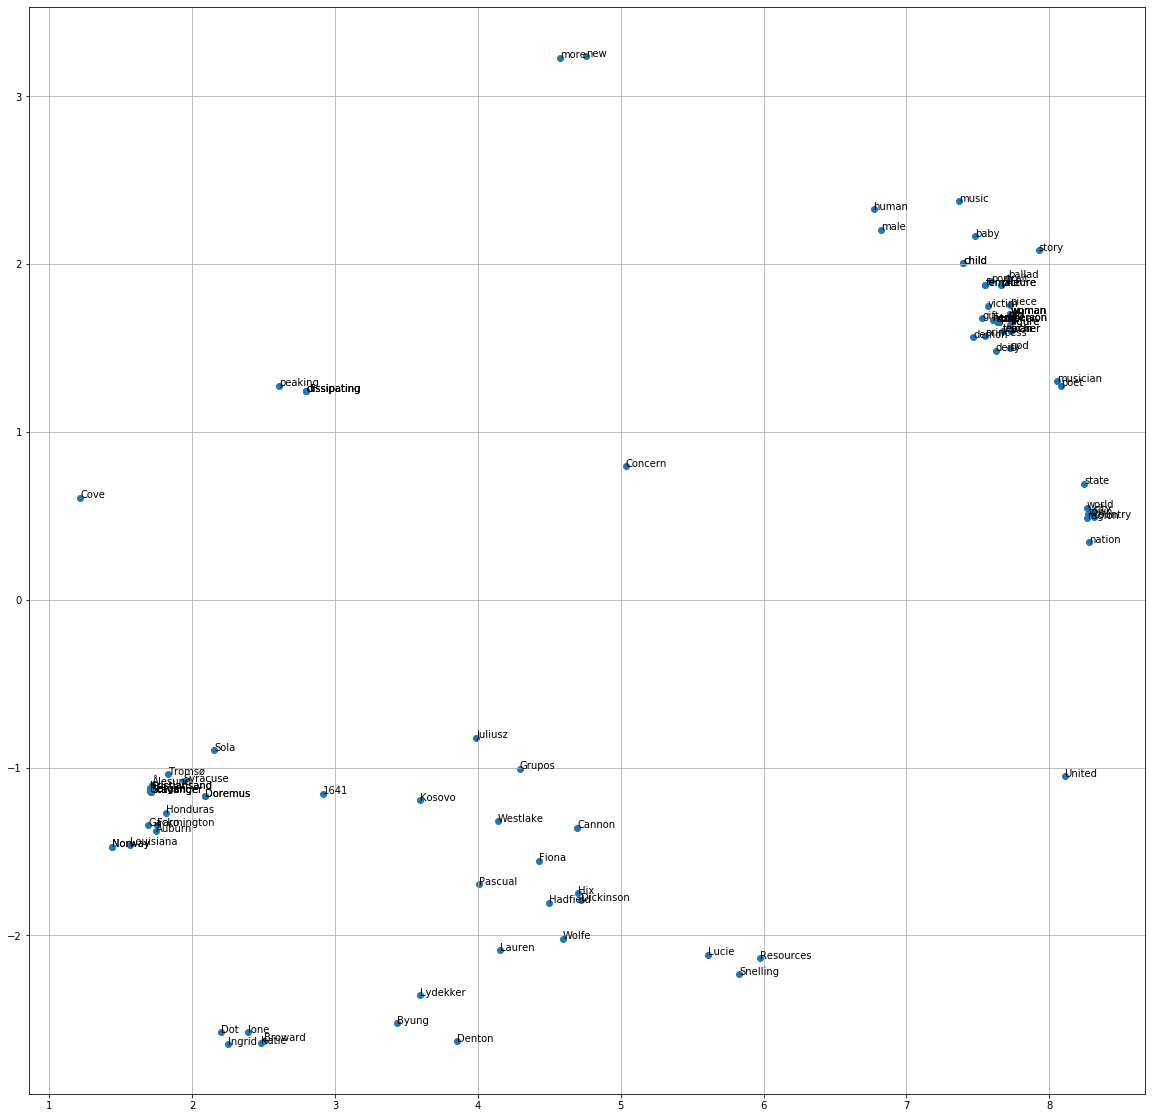

In [23]:
umap_plot(weight_matrix_p, total_idx_p, total_words_p)

In [27]:
print([wikitext_dict.get_token(i) for i in closest_dict_p["world"]])
print([wikitext_dict.get_token(i) for i in farthest_dict_p["world"]])

['country', 'city', 'nation', 'town', 'region', 'more', 'state', 'new', 'United', 'music']
['Fiona', 'Lydekker', 'Denton', 'Wolfe', 'Dickinson', 'Juliusz', 'Grupos', 'Lauren', 'Byung', '1641']


### II.3 Scoring

In [253]:
def get_prob_of_sequence(seq, token = "<eos>"):
    inp = wikitext_dict.encode_token_seq(seq.split(' '))
    target = inp[1:] + [wikitext_dict.get_id(token)]
    
    with torch.no_grad():
        model.eval()
        logits = model(torch.tensor([inp], dtype=torch.long).to(current_device))
    #print(logits.shape) 
    T = len(inp)
    ans = 0
    for i in range(T):
        tokid = target[i]
        prob_distr = torch.softmax(logits[0,i], dim=-1)
        ans += np.log(prob_distr[tokid]).item()
        
    #tokid = wikitext_dict.get_id(token)
    #prob_distr = torch.softmax(logits[0,-1], dim=-1)
    return ans #np.log(prob_distr[tokid]).item(),prob_distr[tokid].item()

seq = "<bos> i have cat"
get_prob_of_sequence(seq)

-42.32510852813721

#### II.3.2 Highest and Lowest scoring sequences

In [182]:
len(wikitext_tensor_dataset["valid"])

8464

In [254]:
seq = [wikitext_dict.get_token(int(j)) for w in wikitext_tensor_dataset["valid"][900][0] for j in w]
seq = " ".join(seq)
get_prob_of_sequence(seq)

-78.060555934906

In [255]:
lst = []
for i,(k,v) in enumerate(wikitext_tensor_dataset["valid"]):
    seq = [wikitext_dict.get_token(int(j)) for w in wikitext_tensor_dataset["valid"][i][0] for j in w]
    seq = " ".join(seq)
    lst.append(get_prob_of_sequence(seq))
    
lst = [i for i in sorted(enumerate(lst), key=lambda x:x[1])]
print(lst)

[(3522, -545.129238357069), (2723, -520.6696688374504), (3689, -516.8957348380936), (5210, -461.44459642400034), (260, -456.3096596598625), (3707, -456.0488815738936), (550, -455.4580908389762), (3712, -447.8008277268964), (918, -446.23796078562737), (4080, -444.97928015782963), (3581, -426.3009789191419), (6738, -425.4147741976776), (3657, -420.8465270679444), (6642, -420.13328752687084), (66, -411.0474037695676), (7526, -410.8739639863488), (1321, -409.98414097656496), (2861, -394.35199899971485), (4293, -384.4008198976517), (6609, -379.3942841203534), (1140, -377.3409592551179), (3555, -377.0133405978322), (4421, -374.87530279904604), (294, -373.4896523618372), (4490, -369.01194564579055), (3204, -367.94483485631645), (7059, -367.7366357250139), (2804, -367.2947869163472), (6799, -366.56288157776), (5094, -366.1569515359588), (5234, -364.2436142992228), (7691, -363.92656544037163), (7445, -362.86462168777507), (3577, -362.371103733778), (3570, -362.2391634879168), (6564, -360.869002

In [256]:
lowest_idx = [l[0] for l in lst[:10]]
lowest_scores = [l[1] for l in lst[:10]]
highest_idx = [l[0] for l in lst[-100:]]
highest_scores = [l[1] for l in lst[-100:]]
#print(highest_idx)
#for i in reversed(highest_idx):
#    seq = [wikitext_dict.get_token(int(j)) for w in wikitext_tensor_dataset["valid"][i][0] for j in w]
#    seq += ["eos"]
#    print(seq)
for i in range(len(highest_idx)):
    idx = highest_idx[i]
    score = highest_scores[i]
    seq = [wikitext_dict.get_token(int(j)) for w in wikitext_tensor_dataset["valid"][idx][0] for j in w]
    seq += ["eos"]
    print(seq,score)

['<bos>', 'The', 'video', 'was', 'also', 'certified', 'gold', 'in', 'Brazil', 'by', 'the', '<unk>', '<unk>', 'eos'] -40.026511907577515
['<bos>', 'Other', 'notable', 'natives', 'of', 'the', 'city', 'include', ':', 'eos'] -39.974472641944885
['<bos>', 'The', '<unk>', 'referred', 'to', 'the', 'invaders', 'as', 'the', '<unk>', '(', 'eos'] -39.95678363740444
['<bos>', 'The', 'song', 'reached', 'number', 'four', 'on', 'the', 'UK', 'Singles', 'Chart', ',', 'and', 'it', 'topped', 'the', 'Irish', 'Singles', 'Chart', '.', 'eos'] -39.91591861343477
['<bos>', 'There', 'is', 'a', 'stone', 'bellcote', 'at', 'the', 'west', 'end', '.', 'eos'] -39.65245231415611
['<bos>', 'He', 'was', 'selected', 'as', 'chairman', 'of', 'the', 'department', 'in', 'June', '2002', '.', 'eos'] -39.62642916390905
['<bos>', 'The', 'song', ',', 'however', ',', 'reached', 'the', 'top', 'of', 'the', 'Hot', 'Dance', 'Club', 'eos'] -39.61652898415923
['<bos>', 'At', 'this', 'time', ',', '<unk>', 'participated', 'in', 'the', 'wi

In [285]:
idx = highest_idx[24]
score = highest_scores[24]
seq = [wikitext_dict.get_token(int(j)) for w in wikitext_tensor_dataset["valid"][idx][0] for j in w]
seq += ["<eos>"]
print(seq,score)

#new_seq = "<bos> The Church of Scientology is present in Germany . <eos>"

['<bos>', 'The', 'Church', 'of', 'Scientology', 'has', 'been', 'present', 'in', 'Germany', 'since', '1970', '.', '<eos>'] -38.570480294089066


#### II.3.3 Modified sequences

In [286]:
new_seq = "<bos> The Church of Scientology has been present in Germany . <eos>"
get_prob_of_sequence(new_seq)

-36.941981678595766

### II.4 Sampling

In [326]:
start_index = torch.tensor([wikitext_dict.get_id("<bos>")])
inp = start_index
model.eval()
out = model.lookup(inp)
out.unsqueeze_(1)
out.shape
out = model.lstm(out)
out = out[0]
out.shape
out = model.projection(out)
out.shape
p = torch.softmax(out[0,-1], dim=-1)
torch.multinomial(p,1)

tensor([100])

In [369]:

for i in range(5):
    start_index = torch.tensor([wikitext_dict.get_id("<bos>")])
    inp = start_index
    sample = ["<bos>"]
    model.eval()
    while inp.item() != wikitext_dict.get_id("<eos>"):
        out = model.lookup(inp)
        out.unsqueeze_(1)
        out = model.lstm(out)
        out = out[0]
        out = model.projection(out)
        p = torch.softmax(out[0,-1], dim=-1)
        #sample_id = torch.argmax(p)
        sample_id = torch.multinomial(p,1).item()
        sample_token = wikitext_dict.get_token(sample_id)
        sample.append(sample_token)
        inp = torch.tensor([wikitext_dict.get_id(sample_token)])
    print(" ".join(sample))
    print("\n")

<bos> The One , Bragg ( The Veerashaiva <unk> <unk> , Barbuda I is a lot at the On One The Lovin " On the By the Gliders in the Tu @-@ constant and songwriter ( The Case for the poem as the keen whereas > @-@ networking ( it was " crowns to predates as the They Remember but he is a decline to the HNC , one " The hacker " The Cerberus was shown at the episode ( The In 1999 , , with Muybridge with Ostend which , Hibari is a [ not been <unk> at No. Battalion that The drunken populace on the Funding to cool ( One , The telescope as several ( 9 @.@ 4 @.@ Infrastructure , and unk> , but have was certainly The In the After the government , is also is a city is a visit to He is only in the musical Cobra <eos>


<bos> After it as similar case , while To This is a 2 <eos>


<bos> However , made the Low from As in allegorical ( orchestra : " ( at the Prohaska @-@ in dockyards to the bright 100 @.@ 4 @.@ some birds , an buyrate that " The Secret with the goddess <unk> , which , and <unk> was two o

In [367]:
wikitext_dict.get_id("@.@")

1132

#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

#### II.4.4 Example Samples